- Make predictions based on majority voting;
- Use bagging to reduce overfitting by drawing random combinations of the training dataset with repetition;
- Apply boosting to build powerful models from weak learners that learn from their mistakes.

# Learning with ensembles

The goal is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone.

The most populare ensemble method is the majority voting principle. It simply means that we select the class label that has been predicted by the majority of the classifiers (50% + 1 votes). This technique is usable only in a binary class setting. For multiclass prediction there is the plurality voting principle.

One prominent approach is the random forest algorithm combining different decision tree classifiers.

Than the formula to choose the label is:
$$\hat{y}=mode\{C_1(x),...,C_m(x)\}$$
Where the mode is the most frequent result in a set.

For a binary classification task where class1=-1 and class2=1 we can write the majority vote prediction as follows:
$$C(x)=sign \bigl[\sum_j^mC_j(x)\bigr]=\begin{cases}1\text{ if }\sum_jC_j(x)\geq 0\\ -1 \text{ otherwise}\end{cases}$$



Let's understand why ensamble learning works by using combinatorics.
Let's make the assumption that all $n$-base classifiers for a binary classification task have an equal error rate $\epsilon$. Let's assume that the classifiers are independent and the error rates are not corretlated.

Under those assumptions, we can express the error probability of an ensemble of base classifiers as a probability mass funtion of a binomial distribution:
$$P(y\geq k)=\sum_{k=\lceil\frac{n}{2}\rceil}^n\binom{n}{k}\epsilon^k(1-\epsilon)^{n-k})=\epsilon_{ensemble}$$
Where $P(y\geq k)$ means "the probability of the number of votes k for the right class, being less than the required".
To compute the probability that the majority is wrong, we take all the possible combinations of majority (from $\lceil\frac{n}{2}\rceil$ to $n$), and then we multiply the probability that we have an error for that specific numerosity of the majority (as a bernuolli distribution: number of k error cases times number of all the rest being correct).

This process generates the probability of the ensemble being wrong.

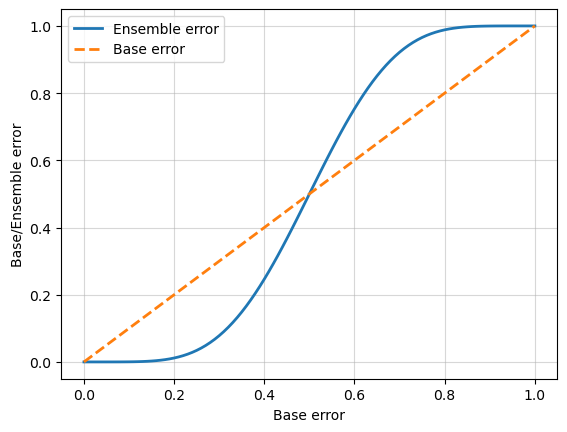

In [1]:
from scipy.special import comb
import math
def ensemble_error(n_classifier,error):
    k_start= int(math.ceil(n_classifier/2))
    probs=[comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k) for k in range(k_start,n_classifier+1)]
    return sum(probs)

import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error) for error in error_range]
plt.plot(error_range,ens_errors,label="Ensemble error",linewidth=2)
plt.plot(error_range,error_range,linestyle="--",label="Base error",linewidth=2)
plt.xlabel("Base error")
plt.ylabel("Base/Ensemble error")
plt.legend(loc="upper left")
plt.grid(alpha=0.5)
plt.show()

As we can observe,the error probability of an ensemble is always better than the error of an idividual base classifier, as long as the base classifiers perform better than random guessing.

# Combining classifiers via majority vote

$$\hat{y}=\argmax_i\sum^m_{j=1}w_j\chi_A\bigl(C_j(x)=i\bigr)$$

Where:
- $w_j$ is the weight associated with the $j$-th classifier;
- $\hat{y}$ is the predicted class label of the ensemble;
- $A$ is the set of unique labels;
- $\chi_A$ is the indicator function, which returns 1 if the predicted class of the $j$-th classifier matches $i$.

If we want equal weights we can just use the mode as we saw before.

If the models output class probabilities though, the formula can be simplified to this:
$$\hat{y}=\argmax_i\sum^m_{j=1}w_jp_{ij}$$

# Using the majority voting principle to make predictions

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty="l2",C=0.001,solver="lbfgs",random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,criterion="entropy",random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric="minkowski")
pipe1 = Pipeline([["sc",StandardScaler()],["clf",clf1]])
pipe3 = Pipeline([["sc",StandardScaler()],["clf",clf3]])
clf_labels = ["logistic regression", "decision tree", "KNN"]

print("10-fold cross validation: \n")
for clf, label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring="roc_auc")
    print(f"ROC AUC: {scores.mean():.2f} +/- {scores.std():.2f} [{label}]")

10-fold cross validation: 

ROC AUC: 0.92 +/- 0.15 [logistic regression]
ROC AUC: 0.87 +/- 0.18 [decision tree]
ROC AUC: 0.85 +/- 0.13 [KNN]


In [3]:
from majority_vote_classifier import MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ["majority voting"]
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf, label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring="roc_auc")
    print(f"ROC AUC: {scores.mean():.2f} +/- {scores.std():.2f} [{label}]")

ROC AUC: 0.92 +/- 0.15 [logistic regression]
ROC AUC: 0.87 +/- 0.18 [decision tree]
ROC AUC: 0.85 +/- 0.13 [KNN]
ROC AUC: 0.98 +/- 0.05 [majority voting]


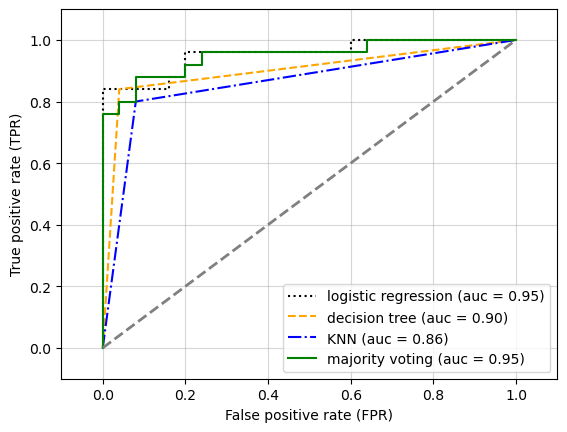

In [4]:
from sklearn.metrics import roc_curve, auc
colors = ["black","orange","blue","green"]
linestyles = [":","--","-.","-"]
for clf, label, clr, ls in zip(all_clf,clf_labels,colors,linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label=f"{label} (auc = {roc_auc:.2f})")
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],linestyle="--",color="gray",linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

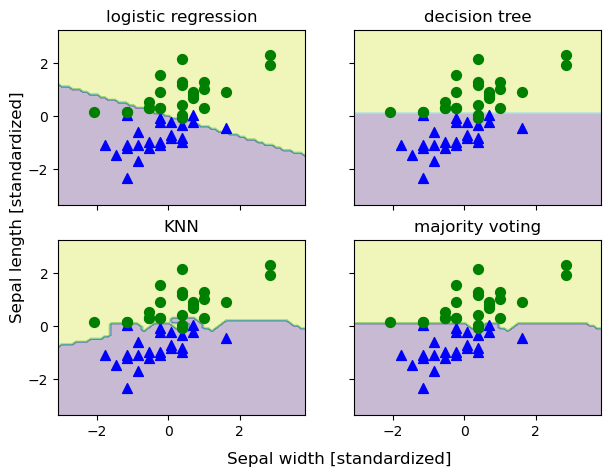

In [5]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:,0].min() - 1
x_max = X_train_std[:,0].max() + 1
y_min = X_train_std[:,1].min() - 1
y_max = X_train_std[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=2,ncols=2,sharex="col",sharey="row",figsize=(7,5))

for idx,clf,tt in zip(product([0,1],[0,1]),all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],X_train_std[y_train==0,1],c="blue",marker="^",s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],X_train_std[y_train==1,1],c="green",marker="o",s=50)
    axarr[idx[0],idx[1]].set_title(tt)

plt.text(-3.5,-5.,s="Sepal width [standardized]",ha="center",va="center",fontsize=12)
plt.text(-12.5,4.5,s="Sepal length [standardized]",ha="center",va="center",fontsize=12,rotation=90)
plt.show()


In [6]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1_memory': None,
 'pipeline-1_steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1_verbose': False,
 'pipeline-1_sc': StandardScaler(),
 'pipeline-1_clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1_sc__copy': True,
 'pipeline-1_sc__with_mean': True,
 'pipeline-1_sc__with_std': True,
 'pipeline-1_clf__C': 0.001,
 'pipeline-1_clf__class_weight': None,
 'pipeline-1_clf__dual': False,
 'pipeline-1_clf__fit_intercept': True,
 'pipeline-1_clf__intercept_scaling': 1,
 'pipeline-1_clf__l1_ratio': None,
 'pipeline-1_clf__max_iter': 100,
 'pipeline-1_clf__multi_class': 'de

In [7]:
from sklearn.model_selection import GridSearchCV
params = {"decisiontreeclassifier_max_depth": [1,2],"pipeline-1_clf__C": [0.001,0.1,100.0]}
grid = GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring="roc_auc")
grid.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier_max_depth': [1, 2],
                         'pipeline-1_clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [8]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_["mean_test_score"][r]
    std_dev = grid.cv_results_["std_test_score"][r]
    params = grid.cv_results_["params"][r]
    print(f"{mean_score:.3f} +/- {std_dev:.2f} {params}")

print(f"Best parameters: {grid.best_params_}")
print(f"ROC AUC: {grid.best_score_:.2f}")

0.983 +/- 0.05 {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier_max_depth': 2, 'pipeline-1_clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier_max_depth': 2, 'pipeline-1_clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier_max_depth': 2, 'pipeline-1_clf__C': 100.0}
Best parameters: {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 0.001}
ROC AUC: 0.98


# Bagging - building an ensemble of classifiers from bootstrap samples

Similar to the majority vote classifier, however instead of using the same training dataset to it the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement, meaning that each dataset that we create will replace some of the components with other dataset elements).

In this way, each classifier will be trained with a slightly different dataset.

In [9]:
import pandas as pd
df_wine = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",
    header=None,
)
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
df_wine = df_wine[df_wine["Class label"]!=1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol',"OD280/OD315 of diluted wines"]].values

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion="entropy",random_state=1,max_depth=None)
bag = BaggingClassifier(
    estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=1
)

from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print(f'Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}')

bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print(f'Bagging train/test accuracies: {bag_train:.3f}/{bag_test:.3f}')
# As we can see the bagging method is more generalizable

Decision tree train/test accuracies: 1.000/0.833
Bagging train/test accuracies: 1.000/0.917


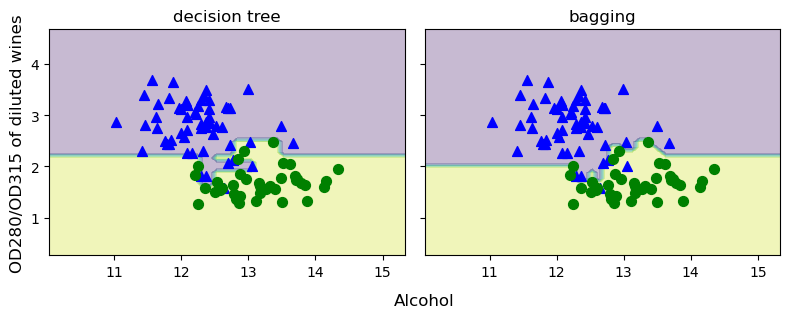

In [10]:
x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=1,ncols=2,sharex="col",sharey="row",figsize=(8,3))

for idx,clf,tt in zip([0,1],[tree, bag],["decision tree", "bagging"]):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1],c="blue",marker="^",s=50)
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1],c="green",marker="o",s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("OD280/OD315 of diluted wines",fontsize=12)
plt.tight_layout()
plt.text(0,-0.2,s="Alcohol",ha="center",va="center",fontsize=12,transform=axarr[1].transAxes)
plt.show()

Bagging is really good to reduce variance but can't do nothing to reduce bias, so it best works with models with low bias.

# Leveraging weak learners via adaptive boosting

In boosting the ensamble consist of very simple base classifiers, also often referred to as weak learners, which often only have a slight performance advantage over random guessing.

The key concept of boosting is to focus on training examples that are hard to classify, that is, to let the weak leraners subsequently learn from misclassified training examples to improve the performance of the ensemble.

## How adaptive boosting works

The original boosting procedure can be summerized in the following four key steps:
1. Draw a random subset of training examples, without replacement, from the training dataset D, to train the weak learner C1;
2. Draw a second random training subset, without replacement from the training dataset and add 50% of the examples that were previously misclassified to train a weak learner;
3. Find the training examples in the training dataset which C1 and C2 disagree upon, to train a third weak learner;
4. Combine the weak learners C1, C2 and C3 via majority voting.

The main perk of boosting is that it decreases in bias as well as variance compared to bagging models.

In contrast to the original boosting procedure described before, **AdaBoost** uses the complete training dataset to train the weak learners, where the training examples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.

The true AdaBoost algorithm:
> NOTE: here $\hat{y}$ and $y$ values goes from -1 to 1 (not from 0 to 1).
1. Set the weight vector, $w$, to uniform weights, where $\sum_iw_i=1$;
2. For $j$ in $m$ boosting rounds, do the following:
    1. Train a weighted weak learner: $C_j=train(X,y,w)$;
    2. Predict class labels: $\hat{y}=predict(C_j,X)$;
    3. Compute the weighted error rate: $\epsilon=w\cdot(\hat{y}\neq y)$ (here is using the dot product);
    4. Compute the coefficient: $\alpha_j = 0.5\log{\frac{1-\epsilon}{\epsilon}}$;
    5. Update the weights: $w:=w\times exp(-\alpha_j\times\hat{y}\times y)$;
    6. Normalize the weights to sum to 1: $w:=\frac{w}{\sum_iw_i}$.
3. Compute the final prediction: $\hat{y}=(\sum_{j=1}^m(\alpha_j\times predict(C_j,X))>0)$.


Decision tree train/test accuracies: 0.916/0.875


/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Decision tree train/test accuracies: 1.000/0.917


/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


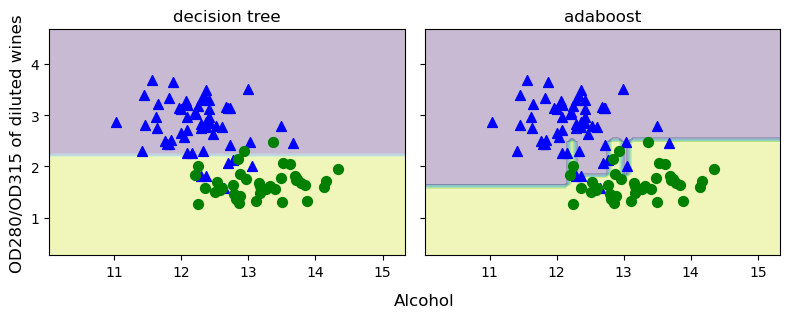

In [11]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
ada = AdaBoostClassifier(estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
tree = tree.fit(X_train,y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print(f'Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print(f'Decision tree train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')

x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=1,ncols=2,sharex="col",sharey="row",figsize=(8,3))

for idx,clf,tt in zip([0,1],[tree, ada],["decision tree", "adaboost"]):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1],c="blue",marker="^",s=50)
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1],c="green",marker="o",s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("OD280/OD315 of diluted wines",fontsize=12)
plt.tight_layout()
plt.text(0,-0.2,s="Alcohol",ha="center",va="center",fontsize=12,transform=axarr[1].transAxes)
plt.show()

> NOTE: more often than not the additional accuracy gains don't justify the additional complexity that ensemble methods bring.    

# Gradient boosting - training an ensemble based on loss gradients

## Comparing AdaBoost with gradient boosting

Like AdaBoost, gradient boosting fits decision trees in an iterative fashion using prediction errors. However, gradient boosting trees are usually deeper than decision tree stumps and have typically a maximum depth of 3 to 6. Also, gradient boosting does not use the prediction errors for assigning sample weights, but instead they are directlly used to form the target variable for fitting the next tree and instead of having an individual weighting term for each tree, gradient boosting uses a global learning rate that is the same for each tree.

## Outlining the general gradient boosting algorithm

In essence, gradient boosting builds a series of trees, where each tree is fit on the error of the previous tree.

Each round, the tree ensemble improves as we are nudging each tree more in the right direction via small updates. These updates are based on a loss gradient, which is how gradient boosting got its name.

Gradient boosting algorithm:
1. Initialize the model to return a constant prediction value (a tree with just one leaf) $\hat{y}$, and this value is found by minimizing a differentiable loss function $L$ that will be defined later ($n$ here refers to the number of training examples):
$$F_0(x) = \argmin_{\hat{y}}\sum_{i=1}^nL(y_i,\hat{y})$$ 
2. For each tree m=1,...,M:
    1. Compute the difference between a predicted value $F(x_i)=\hat{y}_i$ and the class label $y_i$. We can write this value (also called *pseudo-residual*) as the negative gradient of the loss function with resepct to the predicted values: $$r_{im}=-\bigl[\frac{\partial L(y_i,F(x_i))}{\partial F(x_i)}\bigr]_{F(x)=F_{m-1}(x)}$$ Note that $F(x)$ is the prediction of the previous tree $F_{m-1}(x)$. So in the first round it refers to the first single leaf node tree.
    2. Fit a tree to the pseudo-residuals $r_{im}$ (this means that the tree has to be trained upon the tuple $(x,r_{im})$ instead of $(x,y)$). $R_{jm}$ will the denote the $j=1...J_m$ leaf nodes of the resulting tree in iteration $m$.
    3. For each leaf node $R_{jm}$, we compute the following output value: $$ \gamma_{jm} = \argmin_{\gamma}\sum_{x_i\in R_{jm}} L(y_i,F_{m-1}(x_i)+\gamma)$$ Basically every leaf node will have a certain amount of points to it. Here we are trying to find the $\gamma$ for each specific node that added to the output of the previous tree, minimizes the loss function. The found $gamma$ will become the output of that specific leaf node of the new tree;
    4. Update the model by adding the output values $\gamma_m$ to the previous tree: $$F_m(x)=F_{m-1}(x)+\eta\gamma_m$$ Where $\gamma_m$ is the ouput of the newly fitted tree, scaled by a learning rate $\eta$. This way we update the model incrementally by taking small steps which helps avoid overfitting.

## Explaining the gradient boosting algorithm for classification

For a single training example we can specify the logistic loss as follows:
$$L_i = -y_i\log p_i + (1-y_i)\log(1-p_i)$$
Also we introduced in chapter 3 the $\log(odds)$:
$$\hat{y}=\log(odds)=\log(\frac{p}{1-p})$$
The logistic function will be using the $\log(odds)$ to rewrite the logistic function, resulting in this formula:
$$L_i=\log(1+e^{\hat{y}_i})-y_i\hat{y}_i$$
Now we can define the partial derivative of the loss function with respect to these $\log(odds)$:
$$\frac{\partial L_i}{\partial \hat{y}_i}=\frac{e^{\hat{y}_i}}{1+e^{\hat{y}_i}}-y_i=p_i-y_i$$
Then we can apply the algorithm cited before in order to achieve the gradient boosting for the classification problem.

## Using XGBoost

In [13]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    random_state=1,
    max_depth=4
)

gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train,y_train_pred)
gbm_test = accuracy_score(y_test,y_test_pred)
print(f"XGBoost train/test accuracies {gbm_train:.3f}/{gbm_test:.3f}")


/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost train/test accuracies 0.968/0.917
